# Create an image dataset through Google Images 
by: Francisco Ingham and Jeremy Howard. Inspired by Adrian Rosebrock

Note: You will have to repeat these steps for any new category you want to Google (e.g once for dogs and once for cats).


In [1]:
from fastai.vision import *

# Get a list of URLs

## Search and scroll

Go to Google Images and search for the images you are interested in. The more specific you are in your Google Search, the better the results and the less manual pruning you will have to do.

Scroll down until you've seen all the images you want to download, or until you see a button that says 'Show more results'. All the images you scrolled past are now available to download. To get more, click on the button, and continue scrolling. The maximum number of images Google Images shows is 700.

It is a good idea to put things you want to exclude into the search query, for instance if you are searching for the Eurasian wolf, "canis lupus lupus", it might be a good idea to exclude other variants:

       "canis lupus lupus" -dog -arctos -familiaris -baileyi -occidentalis

You can also limit your results to show only photos by clicking on Tools and selecting Photos from the Type dropdown.

# Download into file

Now you must run some Javascript code in your browser which will save the URLs of all the images you want for you dataset.

In **Google Chrome** press **Ctrl+Shift+j on Windows/Linux** or **Cmd+Opt+j on macOS** and a small window the javascript 'Console' will appear.

In **Firefox press** press **Ctrl+Shift+k on Windows/Linux** or **Cmd+Opt+k on macOS**. That is where you will paste the JavaScript commands.

You will need to get the urls of each of the images. Before running the following commands, you may want to disable ad blocking extensions (uBlock, AdBlockPlus etc.) in Chrome. Otherwise the window.open() command doesn't work. Then you can run the following commands:

```Javascript
urls=Array.from(document.querySelectorAll('.rg_i')).map(el=> el.hasAttribute('data-src')?el.getAttribute('data-src'):el.getAttribute('data-iurl'));
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));
```

# Create directory and upload urls file into your server

Choose an appropriate name for your labeled images. You can run these steps multiple times to create different labels.

In [2]:
from fastai import *
from fastai.vision import *

In [3]:
classes = ['GulabJamun','Rasmalai','KajuKatli']
classes_files = ['GulabJamun.csv','Rasmalai.csv','KajuKatli.csv']

You will need to create folders for each category

In [4]:
path = Path('data/Sweets')
for folder in classes:
    dest = path/folder
    dest.mkdir(parents=True, exist_ok=True)

In [5]:
path.ls()

[WindowsPath('data/Sweets/GulabJamun'),
 WindowsPath('data/Sweets/GulabJamun.csv'),
 WindowsPath('data/Sweets/KajuKatli'),
 WindowsPath('data/Sweets/KajuKatli.csv'),
 WindowsPath('data/Sweets/Rasmalai'),
 WindowsPath('data/Sweets/Rasmalai.csv')]

# Download images

Now you will need to download your images from their respective urls.

fast.ai has a function that allows you to do just that. You just have to specify the urls filename as well as the destination folder and this function will download and save all images that can be opened. If they have some problem in being opened, they will not be saved.

Let's download our images! Notice you can choose a maximum number of images to be downloaded. In this case we will not download all the urls.


In [6]:
for folder, file in zip(classes,classes_files):
    print(file)
    dest = path/folder
    download_images(path/file, dest, max_pics=200)

GulabJamun.csv


Rasmalai.csv


KajuKatli.csv


Then we can remove any images that can't be opened

In [7]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

GulabJamun


Rasmalai


KajuKatli


# View Data

In [8]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [9]:
data.classes

['GulabJamun', 'KajuKatli', 'Rasmalai']

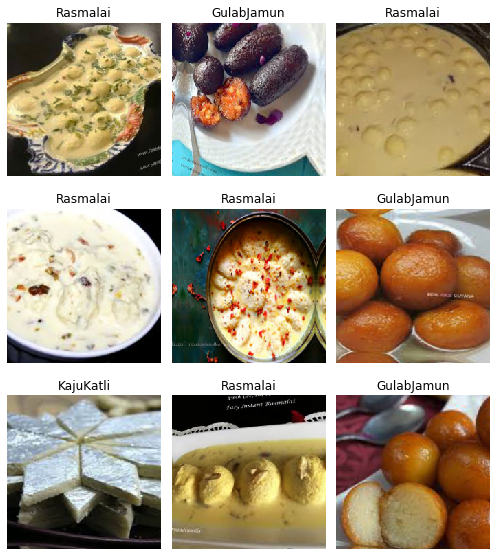

In [10]:
data.show_batch(rows=3, figsize=(7,8))

In [11]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['GulabJamun', 'KajuKatli', 'Rasmalai'], 3, 192, 48)

# Train model

In [12]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [13]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.766484,0.882282,0.312500,00:28
1,1.025776,0.120522,0.041667,00:24
2,0.706801,0.062808,0.041667,00:26
3,0.543574,0.065193,0.041667,00:27


In [14]:
learn.save('stage-1')

In [15]:
learn.unfreeze()

In [16]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


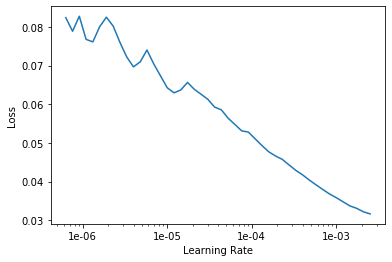

In [17]:
# If the plot is not showing try to give a start and end learning rate
# learn.lr_find(start_lr=1e-5, end_lr=1e-1)
learn.recorder.plot()

In [18]:
learn.fit_one_cycle(2, max_lr=slice(1e-5,3e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.102218,0.012158,0.000000,00:26
1,0.073361,0.004590,0.000000,00:28


In [20]:
learn.save('stage-2')

# Interpretation

In [21]:
learn.load('stage-2');

In [22]:
interp = ClassificationInterpretation.from_learner(learn)

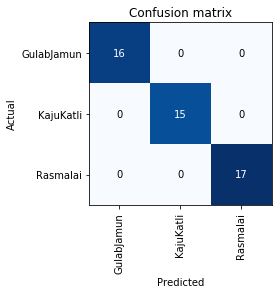

In [23]:
interp.plot_confusion_matrix()

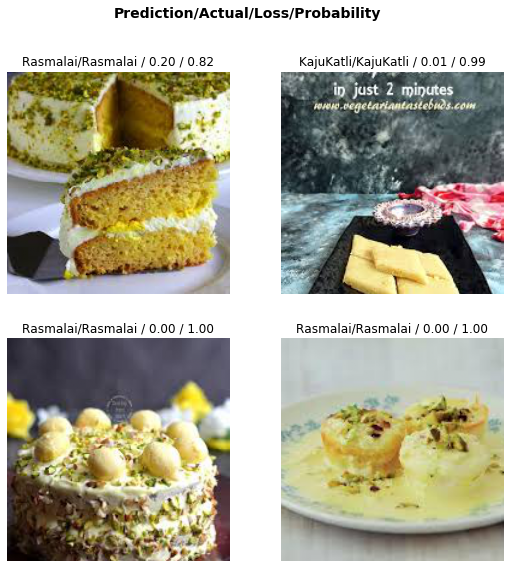

In [24]:
# Show predicted labels of highly misclassified classses
interp.plot_top_losses(4, figsize = (9,9))

# Cleaning Up

Some of our top losses aren't due to bad performance by our model. There are images in our data set that shouldn't be.

Using the ImageCleaner widget from fastai.widgets we can prune our top losses, removing photos that don't belong.

In [25]:
from fastai.widgets import *

First we need to get the file paths from our top_losses. We can do this with .from_toplosses. We then feed the top losses indexes and corresponding dataset to ImageCleaner.

Notice that the widget will not delete images directly from disk but it will create a new csv file cleaned.csv from where you can create a new ImageDataBunch with the corrected labels to continue training your model.

In order to clean the entire set of images, we need to create a new dataset without the split.

In [26]:
losses,idxs = interp.top_losses()
top_loss_path = data.valid_ds.x[idxs]
top_loss_path

ImageList (48 items)
Image (3, 182, 276),Image (3, 272, 186),Image (3, 275, 183),Image (3, 168, 300),Image (3, 233, 216)
Path: data\Sweets

In [27]:
# fd = FileDeleter(file_paths = loss_paths)

In [28]:
db = (ImageList.from_folder(path)
                   .split_none()
                   .label_from_folder()
                   .transform(get_transforms(), size=224)
                   .databunch()
     )

In [29]:
# If you already cleaned your data using indexes from `from_toplosses`,
# run this cell instead of the one before to proceed with removing duplicates.
# Otherwise all the results of the previous step would be overwritten by
# the new run of `ImageCleaner`.

# db = (ImageList.from_csv(path, 'cleaned.csv', folder='.')
#                    .split_none()
#                    .label_from_df()
#                    .transform(get_transforms(), size=224)
#                    .databunch()
#      )

Then we create a new learner to use our new databunch with all the images.

In [30]:
learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)

learn_cln.load('stage-2');

In [31]:
ds, idxs = DatasetFormatter().from_toplosses(learn_cln)

In [32]:
ImageCleaner(ds, idxs, path)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

Flag photos for deletion by clicking 'Delete'. Then click 'Next Batch' to delete flagged photos and keep the rest in that row. ImageCleaner will show you a new row of images until there are no more to show. In this case, the widget will show you images until there are none left from top_losses.ImageCleaner(ds, idxs)

You can also find duplicates in your dataset and delete them! To do this, you need to run .from_similars to get the potential duplicates' ids and then run ImageCleaner with duplicates=True. The API works in a similar way as with misclassified images: just choose the ones you want to delete and click 'Next Batch' until there are no more images left.

Make sure to recreate the databunch and learn_cln from the cleaned.csv file. Otherwise the file would be overwritten from scratch, losing all the results from cleaning the data from toplosses.

In [35]:
ds, idxs = DatasetFormatter().from_similars(learn_cln)

Getting activations...


Computing similarities...


In [36]:
ImageCleaner(ds, idxs, path, duplicates=True)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

Remember to recreate your ImageDataBunch from your cleaned.csv to include the changes you made in your data!



# Putting your model in production

First thing first, let's export the content of our Learner object for production:

In [37]:
learn.export()

This will create a file named 'export.pkl' in the directory where we were working that contains everything we need to deploy our model (the model, the weights but also some metadata like the classes or the transforms/normalization used).

You probably want to use CPU for inference, except at massive scale (and you almost certainly don't need to train in real-time). If you don't have a GPU that happens automatically. You can test your model on CPU like so:

In [38]:
defaults.device = torch.device('cpu')

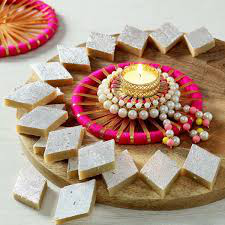

In [39]:
img = open_image(path/'KajuKatli'/'00000072.jpg')
img

In [40]:
learn = load_learner(path)

In [41]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Category KajuKatli

# Things that can go wrong

Most of the time things will train fine with the defaults

    Most likely the hyperparameters need to tune are:
    Learning rate
    Number of epochs

# Learning rate (LR) too high
    Validation loss id very high
    Training loss will be higher than the validation loss

In [42]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [43]:
learn.fit_one_cycle(1, max_lr=0.5)

epoch,train_loss,valid_loss,error_rate,time
0,4.263488,2983087360.000000,0.645833,00:24


# Learning rate (LR) too low
Error rate does not change much

In [44]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [45]:
learn.fit_one_cycle(5, max_lr=1e-5)

epoch,train_loss,valid_loss,error_rate,time
0,2.134471,2.349405,0.666667,00:29
1,2.073610,1.851192,0.625000,00:27
2,2.018535,1.699714,0.645833,00:27
3,1.995916,1.632553,0.604167,00:25
4,1.947811,1.585017,0.666667,00:25


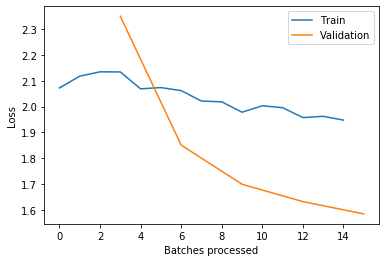

In [46]:
learn.recorder.plot_losses()

As well as taking a really long time, it's getting too many looks at each image, so may overfit.

# Too few epochs

In [47]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate, pretrained=False)

In [48]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,2.250813,24.656876,0.708333,00:27


# Too many epochs

In [49]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.9, bs=16, 
        ds_tfms=get_transforms(do_flip=False, max_rotate=0, max_zoom=1, max_lighting=0, max_warp=0
                              ),size=224, num_workers=4).normalize(imagenet_stats)

In [50]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate, ps=0, wd=0)
learn.unfreeze()

In [51]:
learn.fit_one_cycle(40, slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,1.174810,1.997038,0.689815,00:29
1,1.259802,1.908666,0.675926,00:29
2,1.230271,1.796170,0.652778,00:30
3,1.085705,1.695190,0.638889,00:30
4,1.139326,1.587600,0.615741,00:26
5,1.070909,1.471924,0.583333,00:28
6,1.015957,1.347193,0.569444,00:28
7,0.924047,1.250103,0.532407,00:27
8,0.833168,1.131024,0.495370,00:26
9,0.751985,1.045224,0.430556,00:27


In [52]:
learn.predict??

In [53]:
error_rate??